# Linear Regression

## Team Name
>### Sigma  

## Tem Member
>### 조현윤, 이상협, 정하연  

## Object 
>### It is to build a model that predicts the total ride duration of taxi trips in New York City
>### It is to predict the duration time for each id
>### For each id in the test set, you must predict the value of the trip duration variable

## Evaluation metric 
> Root Mean Squared Logarithmic Error (RMSLE) is calculated as 
>  
> $$ \epsilon = \sqrt{\frac{1}{n} \sum_{i=1}^n (\log(p_i + 1) - \log(a_i+1))^2 } $$  
>  
>Where:  
> \\(\epsilon\\) is the RMSLE value (score)  
> \\(n\\) is the total number of observations in the (public/private) data set,  
> \\(p_i\\) is your prediction of trip duration, and  
> \\(a_i\\) is the actual trip duration for \\(i\\)  
> \\(\log(x)\\) is the natural logarithm of \\(x\\)  

## Submission File
> submission files should contain two columns : **id & trip_duration. **
> id corresponds to **the column of that id in the test.csv**  
> the file should **contain a header and have the following format : **  
~~~~
id,trip_duration
id00001,978
id00002,978
id00003,978
id00004,978
        .
        .
~~~~  

## Data
> ### Description  
> dataset is based on **the 2016 NYC Yellow Cab trip record data** made available in [Big Query on Google Cloud Platform](https://cloud.google.com/bigquery/public-data/nyc-tlc-trips).  
> The data was originally published by the [NYC Taxi and Limousine Commission(TLC)](http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml).  
> The data was sampled and cleaned.  
> ### File Descriptions  
> * train.csv : the training dataset  
> * test.csv : the testing dataset  
> * sample_submission.csv : a sample submission file in the correct format  

> ### Data fields  
> * id - a unique identifier for each trip  
> * vendor_id - a code indicating the provider associated with the trip record  
> * pickup_datetime - date and time when the meter was engaged  
> * dropoff_datetime - date and time when the meter was disengaged  
> * passenger_count - the number of passengers in the vehicle (driver entered value)  
> * pickup_longitude - the longitude where the meter was engaged  
> * pickup_latitude - the latitude where the meter was engaged  
> * dropoff_longitude - the longitude where the meter was disengaged  
> * dropoff_latitude - the latitude where the meter was disengaged  
> * store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip  
> * trip_duration - duration of the trip in seconds  

## Reference  
> [kaggle Homepage-NewYork City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration)  


## Exploratory Data Analysis (EDA ) 

### Load Python Package

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from datetime import datetime
from datetime import date
import seaborn as sns
from shapely.geometry import Point, MultiPolygon
import geojson
import folium
%matplotlib inline

### Definition of Function 

#### Function for Calculating distance between two points using Longitude & Latitude.
> * the direct distance of two GPS location, taking into account that the earth is round.  

In [2]:
def haversine_array(latitude1, longitude1, latitude2, longitude2):
    latitude1, longitude1, latitude2, longitude2 = map(np.radians, (latitude1, longitude1, latitude2, longitude2))
    # The average radius of the earth
    # in km
    AVG_EARTH_RADIUS = 6371
    lat = latitude2 - latitude1
    lng = longitude2 - longitude1
    d = np.sin(lat * 0.5) ** 2 + np.cos(latitude1) * np.cos(latitude2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

 #### Function for Calculating each coordinate of distance.  
> * the usual L1 distance, here the haversine distance is used to calculate each coordinate of distance.  

In [3]:
def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

 #### Function for The direction of the trip
> Using radian as unit.

In [4]:
def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

#### Function for Rest day

In [5]:
def restday(yr,month,day,holidays):
    '''
    Output:
        is_rest: a list of Boolean variable indicating if the sample occurred in the rest day.
        is_weekend: a list of Boolean variable indicating if the sample occurred in the weekend.
    '''
    is_rest    = [None]*len(yr)
    is_weekend = [None]*len(yr)
    i=0
    for yy,mm,dd in zip(yr,month,day):        
        is_weekend[i] = date(yy,mm,dd).isoweekday() in (6,7)
        is_rest[i]    = is_weekend[i] or date(yy,mm,dd) in holidays 
        i+=1
    return is_rest,is_weekend

### Load Training dataet

In [6]:
train = pd.read_csv('./data/train.csv')
#train = pd.read_csv('./data/tranformed_train.csv')
print ("Training data has {} rows and {} columns".format(train.shape[0],train.shape[1]))
print ("data : {}".format(train.shape[0]))
print ("Feature : {}".format(train.shape[1]))

Training data has 701778 rows and 11 columns
data : 701778
Feature : 11


### Check Training dataset

In [7]:
train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,701778.000000,701778.000000,701778.000000,701778.000000,701778.000000,701778.000000,7.017780e+05
mean,1.536037,1.666577,-73.973665,40.750969,-73.973583,40.751836,9.387318e+02
std,0.498700,1.319466,0.043910,0.033139,0.044214,0.037572,6.772504e+03
min,1.000000,0.000000,-78.547401,34.359695,-79.817978,32.181141,1.000000e+00
25%,1.000000,1.000000,-73.991829,40.737400,-73.991325,40.735959,3.900000e+02
50%,2.000000,1.000000,-73.981789,40.754150,-73.979828,40.754478,6.480000e+02
75%,2.000000,2.000000,-73.967567,40.768246,-73.963249,40.769691,1.047000e+03
max,2.000000,8.000000,-61.335529,43.486885,-61.335529,43.674000,3.526282e+06


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701778 entries, 0 to 701777
Data columns (total 11 columns):
id                    701778 non-null object
vendor_id             701778 non-null int64
pickup_datetime       701778 non-null object
dropoff_datetime      701778 non-null object
passenger_count       701778 non-null int64
pickup_longitude      701778 non-null float64
pickup_latitude       701778 non-null float64
dropoff_longitude     701778 non-null float64
dropoff_latitude      701778 non-null float64
store_and_fwd_flag    701778 non-null object
trip_duration         701778 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 58.9+ MB


### Check Whether missing value exists

In [9]:
print ('There are not Missing Values') if np.any(train != np.NaN) else print ('There are Missing Values')

There are not Missing Values


In [10]:
x = [ feature for feature in list(train.describe().keys()) if train.describe()[feature]['count'] == train.shape[0] ]
print ('{}, {}'.format(len(train.describe().keys()), len(x)))

7, 7


* missing value는 존재하지 않음

 ### Check Whether ID is unique
> * a unique identifier for each trip

In [11]:
print('Id is unique. Count : {}'.format(train.shape[0])) if train.id.nunique() == train.shape[0] else print('oops')
train.isnull().sum(axis=0).reset_index()

Id is unique. Count : 701778


,index,0
0,id,0
1,vendor_id,0
2,pickup_datetime,0
3,dropoff_datetime,0
4,passenger_count,0
5,pickup_longitude,0
6,pickup_latitude,0
7,dropoff_longitude,0
8,dropoff_latitude,0
9,store_and_fwd_flag,0


* ID는 고유의 값을 가지고 있음

### Check dependent variable
> * duration of the trip in seconds

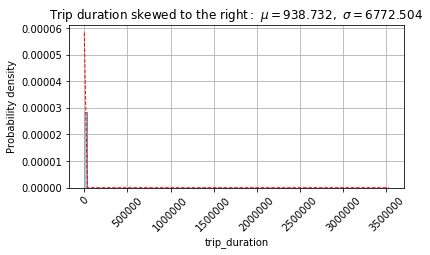

,count,mean,std,min,25%,50%,75%,max
trip_duration,701778.0,938.731817,6772.504153,1.0,390.0,648.0,1047.0,3526282.0


In [12]:
import matplotlib.mlab as mlab
# Mean distribution
mu = train['trip_duration'].mean()
# Std distribution
sigma = train['trip_duration'].std()
num_bins = 100
# Histogram 
fig = plt.figure(figsize=(6,3))
n, bins, patches = plt.hist(train['trip_duration'], num_bins, normed=1,
                           edgecolor = 'black', lw = 1, alpha = .40)
# Normal Distribution
y = mlab.normpdf(bins, mu, sigma)
plt.xticks(rotation = 45)
plt.plot(bins, y, 'r--', linewidth=1)
plt.xlabel('trip_duration')
plt.ylabel('Probability density')
# Adding a title
plt.title(r'$\mathrm{Trip\ duration\ skewed \ to \ the \ right:}\ \mu=%.3f,\ \sigma=%.3f$'%(mu,sigma))
plt.grid(True)
#fig.tight_layout()
plt.show()

train.describe()[['trip_duration']].transpose()

* dependent variable : trip_duration
> * 좌측으로 편중되어 있음을 확인

### Confirm Features

#### vendor_id
> * a code indicating the provider associated with the trip record

In [14]:
countVendorID = train['vendor_id'].value_counts().sort_index()
print (countVendorID)

1    325599
2    376179
Name: vendor_id, dtype: int64


,count,mean,std,min,25%,50%,75%,max
vendor_id,,,,,,,,
1,325599.0,837.073081,8845.435788,1.0,388.0,644.0,1041.0,3526282.0
2,376179.0,1026.721797,4222.366691,1.0,392.0,652.0,1052.0,86369.0


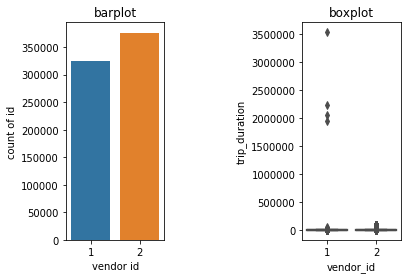

In [15]:
plt.subplot(131)
plt.title('barplot')
sns.barplot(countVendorID.index,  countVendorID.values)
plt.xlabel('vendor id')
plt.ylabel('count of id')
plt.subplot(133)
plt.title('boxplot')
sns.boxplot(x = 'vendor_id', y = 'trip_duration',
            data = train, palette = 'gist_rainbow', linewidth = 2.3)
train.groupby('vendor_id')['trip_duration'].describe()

* vendor_id
> * 1, 2의 값만을 가짐
> * **Category value**
> * dependent variable인 trip_duration과 연관성이 크지 않은 것으로 판단 
> * independent variable 선정시 후순위로 고려

### store_and_fwd_flag
* This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server 
* Y=store and forward; N=not a store and forward trip

In [43]:
countStore_and_fwd_flag = train['store_and_fwd_flag'].value_counts().sort_index()
print (countStore_and_fwd_flag)

N    697920
Y      3858
Name: store_and_fwd_flag, dtype: int64


,count,mean,std,min,25%,50%,75%,max
store_and_fwd_flag,,,,,,,,
N,697920.0,938.281064,6790.894652,1.0,390.0,648.0,1045.0,3526282.0
Y,3858.0,1020.273976,858.255419,2.0,447.0,769.0,1308.0,6421.0


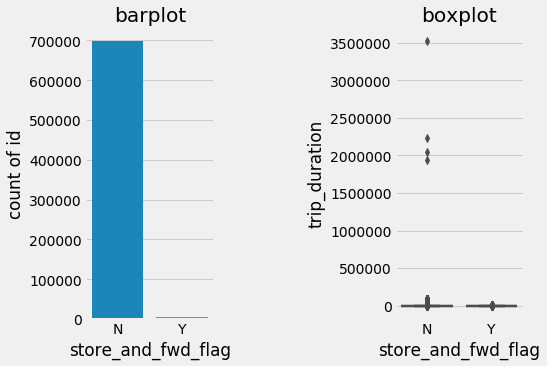

In [47]:
matplotlib.style.use('fivethirtyeight')
plt.figure(figsize=(7,5))
plt.subplot(131)
plt.title('barplot')
sns.barplot(countStore_and_fwd_flag.index, countStore_and_fwd_flag.values)
plt.xlabel('store_and_fwd_flag')
plt.ylabel('count of id')
plt.subplot(133)
plt.title('boxplot')
sns.boxplot(x = 'store_and_fwd_flag', y = 'trip_duration', data = train, 
                          palette = 'gist_rainbow', linewidth = 2.3)
#plt.subplot(155)
#plt.title('boxplot')
#sns.boxplot(x = 'store_and_fwd_flag', y = 'distance', data = train, 
#                          palette = 'gist_rainbow', linewidth = 2.3)

train.groupby('store_and_fwd_flag')['trip_duration'].describe()

* store_and_fwd_flag
 * Y, N 의 값을 가진다.
  * **Category value **
  * 'N'의 Category에서 데이터의 std가 높게 나타나며 최고값도 크게 나타는 것으로 보아 아웃라이어로 인한 영향으로 보임

### Passenger_Count
> * the number of passengers in the vehicle (driver entered value)

In [48]:
countPassenger_Count = train['passenger_count'].value_counts().sort_index()
print (countPassenger_Count)

0        31
1    497800
2    100422
3     28321
4     13568
5     38131
6     23503
7         1
8         1
Name: passenger_count, dtype: int64


,count,mean,std,min,25%,50%,75%,max
passenger_count,,,,,,,,
0,31.0,424.129032,810.165158,2.0,6.0,22.0,347.5,3243.0
1,497800.0,916.178276,7146.422856,1.0,385.0,641.0,1035.0,3526282.0
2,100422.0,979.294686,7149.079164,1.0,409.0,675.0,1092.0,2049578.0
3,28321.0,978.539529,3588.933985,2.0,409.0,666.0,1067.0,86331.0
4,13568.0,1009.773143,3613.022418,4.0,412.0,684.0,1110.0,86366.0
5,38131.0,1027.267814,4242.022608,2.0,395.0,654.0,1052.0,86360.0
6,23503.0,1011.241714,4143.782730,3.0,388.5,647.0,1044.0,86354.0
7,1.0,25.000000,NaN,25.0,25.0,25.0,25.0,25.0
8,1.0,104.000000,NaN,104.0,104.0,104.0,104.0,104.0


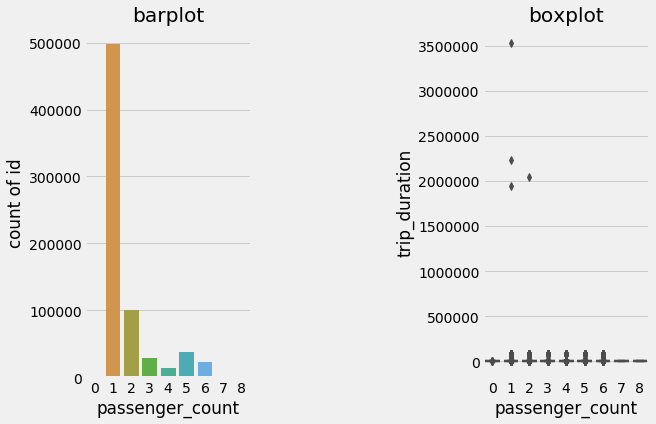

In [49]:
import matplotlib
matplotlib.style.use('fivethirtyeight')
plt.figure(figsize=(9,6))
plt.subplot(131)
plt.title('barplot')
sns.barplot(countPassenger_Count.index, countPassenger_Count.values)
plt.xlabel('passenger_count')
plt.ylabel('count of id')
plt.subplot(133)
plt.title('boxplot')
sns.boxplot(x = 'passenger_count', y = 'trip_duration', data = train, 
                          palette = 'gist_rainbow', linewidth = 2.3)
train.groupby('passenger_count')['trip_duration'].describe()


* passenger Count
 * 0, 1, 2, 3, 4, 5, 6, 7, 8의 값을 가진다
 * 해당 데이터의 정보에서 택시에 탑승한 승객의 수를 이야기한다. 
 * value가 0인 데이터는 제거하는 것이 필요한 것으로 보임

### pickup_datetime
> * date and time when the meter was engaged  

In [16]:
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'])

* pickup_datetime은 type이 object로 저장되어 있어 datetime64[ns]으로 변경후 진행

In [17]:
train['dropoff_datetime'] = pd.to_datetime(train['dropoff_datetime'])

* dropoff datetime은  test data set에서는 생략된 변수이나 후에 speed를 계산하기 위해 type을 변경

In [18]:
train['pickup_date'] = train['pickup_datetime'].dt.date # Extract date
train['pickup_time'] = train['pickup_datetime'].dt.time # Extract time

* pickup_date : pickup_datetime의 날짜 정보 추출
* pickup_time : pickup_datetime의 시간 정보 추출

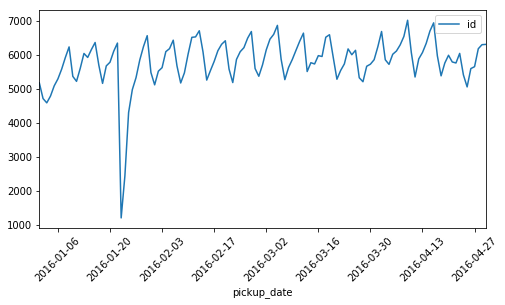

In [25]:
pickups_by_day = train.groupby('pickup_date').count()['id']
pickups_graph = pickups_by_day.plot(x = 'pickup_date', y = 'id', figsize = (8,4),legend = True,rot = 45)
pickups_graph.set_xlim(left = '2016-01-01', right = '2016-04-30')
plt.show()

> 2016.01.01 ~ 2016.04.30까지 Newyork의 택시 데이터의 분포를 확인
> * 2016년 01월 22일, 2016년 01월 23일 택시의 데이터 량이 감소
> * 주기성이 보이는 것을 확인

#### Year

In [19]:
train['year']=train['pickup_datetime'].dt.year
train['pickup_datetime'].dt.year.value_counts().sort_index()

2016    701778
Name: pickup_datetime, dtype: int64

> 2016년의 정보만 있는 것으로 확인
> * 하나의 값만 가지고 있어 변수로써 가치는 없는 것으로 판단

#### Month

In [20]:
train['month'] = train['pickup_datetime'].dt.month
countMonth = train['pickup_datetime'].dt.month.value_counts().sort_index()
print (countMonth)

1    165104
2    171599
3    184135
4    180940
Name: pickup_datetime, dtype: int64


* month
 * 1~4월까지 1/1 ~ 4/30일까지의 정보

,count,mean,std,min,25%,50%,75%,max
month,,,,,,,,
1,165104.0,930.089628,7919.125268,1.0,383.0,629.0,1012.0,2227612.0
2,171599.0,929.827406,10306.592822,1.0,384.0,635.0,1023.0,3526282.0
3,184135.0,935.931729,3188.142351,1.0,393.0,654.0,1054.0,86366.0
4,180940.0,957.911888,3096.073842,1.0,403.0,674.0,1095.0,86364.0


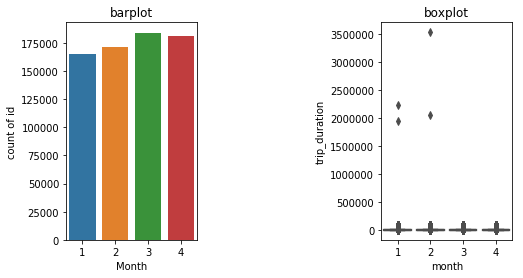

In [21]:
plt.figure(figsize=(8,4))
plt.subplot(131)
plt.title('barplot')
sns.barplot(countMonth.index, countMonth.values)
plt.xlabel('Month')
plt.ylabel('count of id')
plt.subplot(133)
plt.title('boxplot')
sns.boxplot(x = 'month', y = 'trip_duration', data = train, palette = 'gist_rainbow', linewidth = 2.3)
train.groupby('month')['trip_duration'].describe()


* 월별로 데이터 분포의 차이를 보이지 않아 보임
* independent variable을 위한 변수 선정시 후순위로 고려

#### Day

In [22]:
train['day']   = train['pickup_datetime'].dt.day

In [23]:
countDay = train['day'].value_counts().sort_index()

,count,mean,std,min,25%,50%,75%,max
day,,,,,,,,
1,22225.0,917.830551,3144.149543,2.0,390.00,644.0,1048.0,86353.0
2,23054.0,889.188948,3086.208219,2.0,383.00,633.0,1015.0,86362.0
3,22515.0,946.508905,3680.316723,1.0,375.00,633.0,1028.0,86346.0
4,23191.0,920.353887,3062.651711,2.0,385.00,634.0,1038.0,86354.0
5,24143.0,1100.426790,19309.206279,2.0,382.00,634.0,1022.5,2227612.0
6,23698.0,884.414508,3095.348607,2.0,379.00,624.0,1001.0,86345.0
7,22806.0,848.811760,2246.245113,1.0,385.00,635.0,1010.0,86364.0
8,23254.0,897.764643,2829.322186,2.0,389.00,644.0,1040.0,86344.0
9,24574.0,866.072963,2825.434877,1.0,384.25,632.0,996.0,86366.0


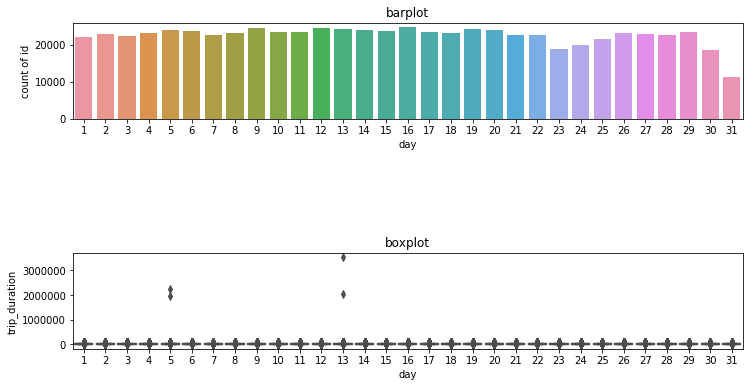

In [24]:
plt.figure(figsize=(12,6))
plt.subplot(311)
plt.title('barplot')
sns.barplot(countDay.index, countDay.values)
plt.xlabel('day')
plt.ylabel('count of id')
plt.subplot(313)
plt.title('boxplot')
sns.boxplot(x = 'day', y = 'trip_duration', data = train, 
                          palette = 'gist_rainbow', linewidth = 2.3)
train.groupby('day')['trip_duration'].describe()


* 1월 : 31일
* 2월 : 29일
* 3월 : 31일
* 4월 : 30일
* 추가적인 분석을 통하여 달라질 수 있는 여지가 있으나 단일 독립변수로는 적절하지 않아 보임

#### Hour

In [26]:
train['hr'] = train['pickup_datetime'].dt.hour

In [27]:
countHour = train['hr'].value_counts().sort_index()

,count,mean,std,min,25%,50%,75%,max
hr,,,,,,,,
0,25191.0,958.236394,12629.340880,1.0,385.0,637.0,1018.00,1939736.0
1,18339.0,869.052729,3421.625384,2.0,367.0,606.0,964.00,86234.0
2,13439.0,885.314756,3981.912288,2.0,353.0,591.0,939.00,86366.0
3,10025.0,876.177756,3767.233735,2.0,353.0,595.0,956.00,86325.0
4,7486.0,932.554368,4129.867807,1.0,339.0,603.0,1021.75,86265.0
5,7080.0,802.522599,2701.765864,1.0,283.0,516.0,997.00,86277.0
6,15665.0,865.562975,17918.527686,2.0,287.0,468.0,801.00,2227612.0
7,26728.0,822.983688,2617.565036,2.0,351.0,565.0,902.00,86335.0
8,32183.0,918.241618,3033.699771,2.0,387.0,646.0,1043.00,86345.0


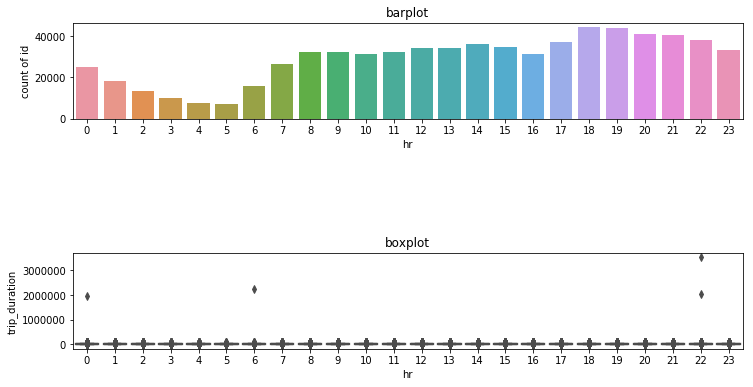

In [28]:
plt.figure(figsize=(12,6))
plt.subplot(311)
plt.title('barplot')
sns.barplot(countHour.index,countHour.values)
plt.xlabel('hr')
plt.ylabel('count of id')
plt.subplot(313)
plt.title('boxplot')
sns.boxplot(x = 'hr', y = 'trip_duration', data = train, 
                          palette = 'gist_rainbow', linewidth = 2.3)
train.groupby('hr')['trip_duration'].describe()



> 0~23시까지의 값을 가짐
> * 0~7시에는 다른 시간대보다 데이터량이 감소함
> * 사전지식을 기반으로 하여 새벽 시간대 전체 교통량도 감소하는 것으로 보임
> * independent Variable로 가능할 것으로 보임

#### Minute

In [29]:
train['minute']= train['pickup_datetime'].dt.minute
countMinute = train['minute'].value_counts().sort_index()

,count,mean,std,min,25%,50%,75%,max
minute,,,,,,,,
0,11474.0,916.026059,2972.007834,1.0,389.00,647.0,1044.75,86331.0
1,11531.0,925.533952,3115.040535,1.0,389.00,648.0,1044.00,86277.0
2,11631.0,924.852549,3111.066317,1.0,389.00,641.0,1053.00,86346.0
3,11554.0,973.827592,3680.193511,2.0,388.00,646.0,1047.00,86360.0
4,11435.0,979.190993,3747.547871,2.0,393.00,650.0,1049.00,86364.0
5,11614.0,941.748407,3198.386219,2.0,392.00,657.0,1064.00,86316.0
6,11746.0,979.719309,3737.438595,2.0,393.00,654.5,1055.00,86358.0
7,11567.0,1016.285035,4064.490219,2.0,399.00,664.0,1062.50,86345.0
8,11924.0,942.777508,3266.521777,2.0,393.00,656.0,1058.00,86320.0


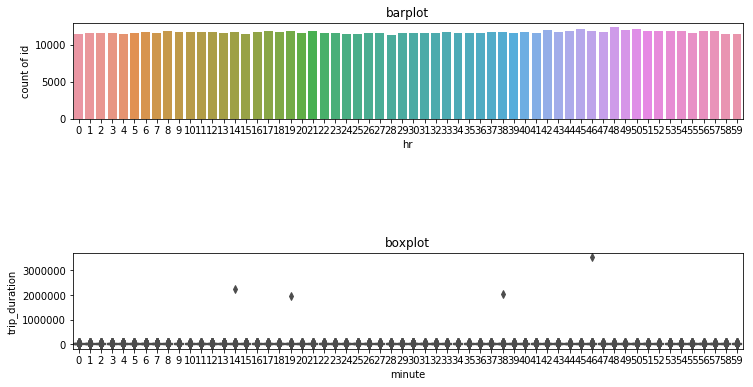

In [30]:
plt.figure(figsize=(12,6))
plt.subplot(311)
plt.title('barplot')
sns.barplot(countMinute.index,countMinute.values)
plt.xlabel('hr')
plt.ylabel('count of id')
plt.subplot(313)
plt.title('boxplot')
sns.boxplot(x = 'minute', y = 'trip_duration', data = train, 
                          palette = 'gist_rainbow', linewidth = 2.3)
train.groupby('minute')['trip_duration'].describe()

> 분포 상의 차이를 보이는 부분이 없는 것을 확인
> * dependent Variable로써 가능하지 않은 것으로 보임

#### Day of Week

In [31]:
train['day_of_week'] = train['pickup_datetime'].dt.dayofweek

In [32]:
countDayOfWeek = train['day_of_week'].value_counts().sort_index()
print (countDayOfWeek)

0     88552
1     95208
2     99212
3    103534
4    112378
5    110500
6     92394
Name: day_of_week, dtype: int64


,count,mean,std,min,25%,50%,75%,max
day_of_week,,,,,,,,
0,88552.0,883.254946,2816.754634,1.0,375.00,615.0,1001.0,86358.0
1,95208.0,975.235075,10009.627304,1.0,399.00,661.0,1074.0,2227612.0
2,99212.0,936.245565,2891.077968,1.0,404.00,671.0,1087.0,86366.0
3,103534.0,965.337029,2949.417912,1.0,413.00,693.0,1119.0,86346.0
4,112378.0,968.522344,3306.655759,1.0,404.25,674.0,1086.0,86360.0
5,110500.0,943.121629,12714.000224,1.0,381.00,626.0,994.0,3526282.0
6,92394.0,885.659469,3490.253901,1.0,359.00,594.0,959.0,86369.0


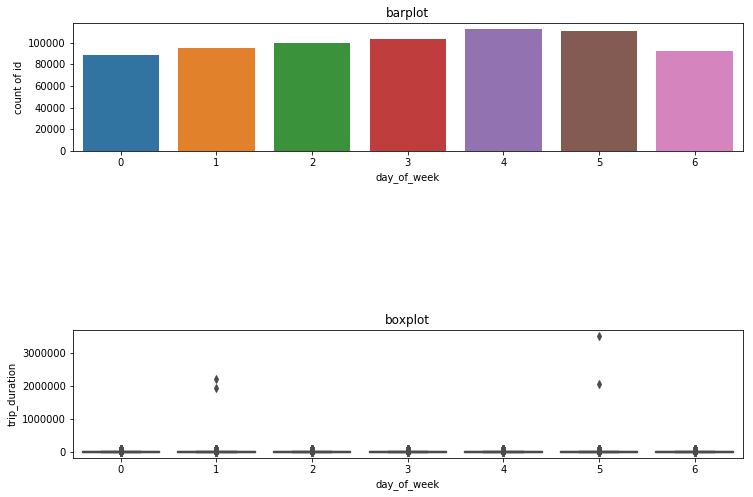

In [33]:
plt.figure(figsize=(12,8))
plt.subplot(311)
plt.title('barplot')
sns.barplot(countDayOfWeek.index,countDayOfWeek.values)
plt.xlabel('day_of_week')
plt.ylabel('count of id')
plt.subplot(313)
plt.title('boxplot')
sns.boxplot(x = 'day_of_week', y = 'trip_duration', data = train, 
                          palette = 'gist_rainbow', linewidth = 2.3)
train.groupby('day_of_week')['trip_duration'].describe()


> day_of_week (요일) 
> * 0~6(월~일)
> * 단일하게 사용될 경우 큰 차이를 보이지 않는 것으로 보임
> * 사전지식으로 파악했을때 평일과 주말사이 다른 동향을 보일 것으로 예상

* day_of_week과 hr의 변수를 같이 보고자함

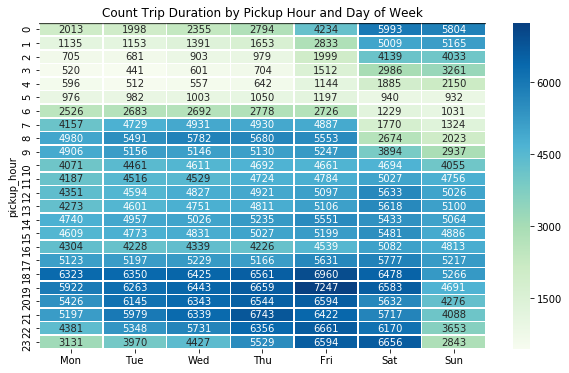

count         mean           std   min     25%    50%  \
hr day_of_week                                                           
0  0            2013.0   810.039742   3292.752822   3.0  334.00  572.0   
   1            1998.0  1803.868869  43473.091138   4.0  354.00  592.0   
   2            2355.0   797.247134   2522.772053   3.0  358.00  598.0   
   3            2794.0   829.954188   2844.269587   2.0  364.00  612.5   
   4            4234.0   966.657770   4128.586898   3.0  376.00  627.0   
   5            5993.0   932.577007   3315.464362   1.0  416.00  662.0   
   6            5804.0   865.958132   2772.879239   2.0  417.00  670.0   
1  0            1135.0   743.129515   2478.400714   4.0  329.50  540.0   
   1            1153.0   908.713790   4181.836308  11.0  337.00  591.0   
   2            1391.0   783.547807   3031.679708   8.0  334.00  540.0   
   3            1653.0   821.438596   3585.791537   5.0  325.00  558.0   
   4            2833.0   859.376633   3208.432763   6.0  367.00  600.0   
   5            5009.0   880.925933   3408.813631   2.0  388.00  632.0   
   6            5165.0   919.929138   3579.634915   2.0  391.00  635.0   
2  0             705.0   804.351773   3246.178049   4.0  317.00  576.0   
   1             681.0   926.229075   4609.092584   9.0  333.00  561.0   
   2             903.0   833.146179   4038.437615   7.0  312.00  537.0   
   3             979.0   770.764045   2519.887504   7.0  343.50  587.0   
   4            1999.0   819.774887   3284.006365   3.0  340.50  568.0   
   5            4139.0   913.971249   4078.403796   5.0  362.00  600.0   
   6            4033.0   935.122489   4450.538391   2.0  372.00  605.0   
3  0             520.0   716.784615    510.566465   4.0  325.50  585.0   
   1             441.0   673.086168    448.996312   9.0  314.00  570.0   
   2             601.0   790.377704   3427.970945   3.0  321.00  551.0   
   3             704.0   710.041193    493.724680   3.0  319.75  590.0   
   4            1512.0  1048.441138   5368.356161   3.0  345.00  586.0   
   5            2986.0   888.027796   3830.216188   2.0  354.25  588.5   
   6            3261.0   890.016253   3812.173577   3.0  376.00  614.0   
4  0             596.0  1040.958054   4933.771849   3.0  324.75  633.5   
   1             512.0   700.050781    488.710265   3.0  321.00  569.0   
...                ...          ...           ...   ...     ...    ...   
19 5            6583.0   950.474859   3356.263088   2.0  424.00  699.0   
   6            4691.0   934.235344   3961.021908   3.0  363.50  594.0   
20 0            5426.0   764.972171   2368.799513   2.0  362.00  576.5   
   1            6145.0   820.350854   2700.193587   2.0  380.00  609.0   
   2            6343.0   852.204004   2847.876818   3.0  396.00  636.0   
   3            6544.0   943.919468   3527.737191   2.0  412.00  680.0   
   4            6594.0   910.139066   3172.556907   2.0  408.00  663.0   
   5            5632.0   895.351562   3041.537920   3.0  408.00  663.0   
   6            4276.0   987.680776   4710.679194   2.0  351.00  574.0   
21 0            5197.0   745.847797   1744.652239   2.0  369.00  587.0   
   1            5979.0   838.615655   2955.659923   2.0  396.00  622.0   
   2            6339.0   832.580060   2289.417029   2.0  403.00  646.0   
   3            6743.0   906.231351   2787.405132   2.0  422.00  682.0   
   4            6422.0   897.662566   3052.517323   2.0  413.25  670.0   
   5            5717.0   933.338289   3757.536468   3.0  404.00  651.0   
   6            4088.0   913.224315   4193.979416   4.0  339.00  555.5   
22 0            4381.0   822.597124   2834.884686   3.0  359.00  581.0   
   1            5348.0   943.823298   3879.273740   7.0  391.00  639.0   
   2            5731.0   895.427500   3195.717765   1.0  402.00  651.0   
   3            6356.0   977.599119   3558.448348   3.0  418.00  694.0   
   4            6661.0   931.771206   2992.978439   3.0  424.00  700.0   
   5            6170.

In [39]:
# Trips by Hour and Day of Week
trip_duration_median = train['trip_duration'].median()
plt.figure(figsize=(10,6))
pickup_hourdayweek = train.groupby(['hr','day_of_week'])['id'].count().unstack()
hourday_graph = sns.heatmap(pickup_hourdayweek,
                                   lw = .5, annot = True, cmap = 'GnBu', fmt = 'g',annot_kws = {"size":10} )
# Customize tick label size
hourday_graph.tick_params(axis = 'both', which = 'major', labelsize = 10)

# Customize tick labels of the y-axis
hourday_graph.set_xticklabels(labels = ['Mon', 'Tue', 'Wed','Thu','Fri','Sat','Sun'])

# Bolding horizontal line at y = 0
hourday_graph.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .70)

# Remove the label of the x-axis
hourday_graph.xaxis.label.set_visible(False)

# Add signature bar
plt.ylabel('pickup_hour')
plt.xlabel('pickup_weekday (Mon - Sun)')
plt.title('Count Trip Duration by Pickup Hour and Day of Week')
plt.show()
train.groupby(['hr','day_of_week'])['trip_duration'].describe()

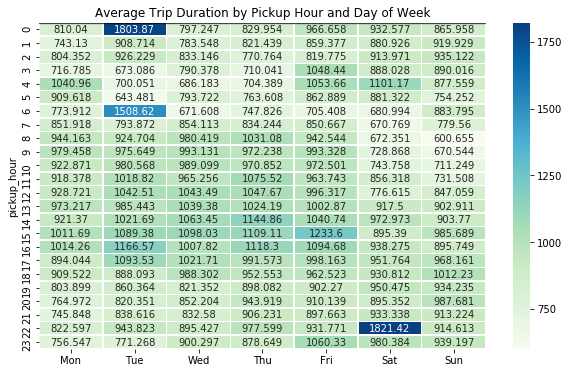

In [40]:
# Trips by Hour and Day of Week
plt.figure(figsize=(10,6))
pickup_speed = train.groupby(['hr','day_of_week'])['trip_duration'].mean().unstack()
hourday_graph = sns.heatmap(pickup_speed,
                                   lw = .5, annot = True, cmap = 'GnBu', fmt = 'g',annot_kws = {"size":10} )
# Customize tick label size
hourday_graph.tick_params(axis = 'both', which = 'major', labelsize = 10)

# Customize tick labels of the y-axis
hourday_graph.set_xticklabels(labels = ['Mon', 'Tue', 'Wed','Thu','Fri','Sat','Sun'])

# Bolding horizontal line at y = 0
hourday_graph.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .70)

# Remove the label of the x-axis
hourday_graph.xaxis.label.set_visible(False)

# Add signature bar
plt.ylabel('pickup_hour')
plt.xlabel('pickup_weekday (Mon - Sun)')
plt.title('Average Trip Duration by Pickup Hour and Day of Week')
plt.show()

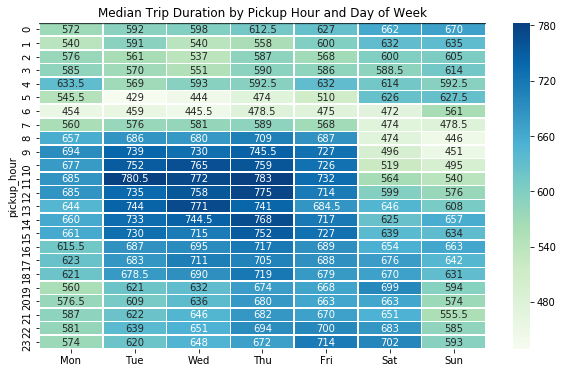

In [41]:
# Trips by Hour and Day of Week
plt.figure(figsize=(10,6))
pickup_hourday = train.groupby(['hr','day_of_week'])['trip_duration'].median().unstack()
hourday_graph = sns.heatmap(pickup_hourday,
                                   lw = .5, annot = True, cmap = 'GnBu', fmt = 'g',annot_kws = {"size":10} )
# Customize tick label size
hourday_graph.tick_params(axis = 'both', which = 'major', labelsize = 10)

# Customize tick labels of the y-axis
hourday_graph.set_xticklabels(labels = ['Mon', 'Tue', 'Wed','Thu','Fri','Sat','Sun'])

# Bolding horizontal line at y = 0
hourday_graph.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .70)

# Remove the label of the x-axis
hourday_graph.xaxis.label.set_visible(False)

# Add signature bar
plt.ylabel('pickup_hour')
plt.xlabel('pickup_weekday (Mon - Sun)')
plt.title('Median Trip Duration by Pickup Hour and Day of Week')
plt.show()

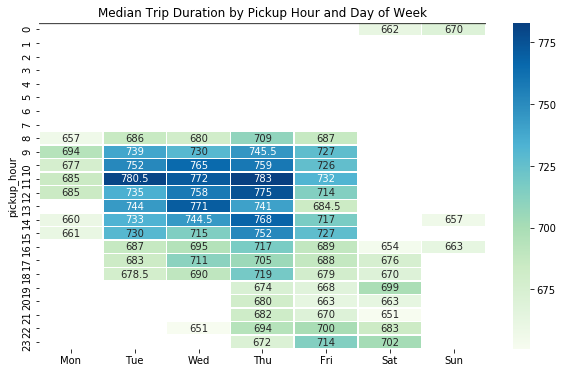

In [42]:
# Trips by Hour and Day of Week
trip_duration_median = train['trip_duration'].median()
plt.figure(figsize=(10,6))
pickup_hourday = train.groupby(['hr','day_of_week'])['trip_duration'].median().unstack()
hourday_graph = sns.heatmap(pickup_hourday[pickup_hourday>trip_duration_median],
                                   lw = .5, annot = True, cmap = 'GnBu', fmt = 'g',annot_kws = {"size":10} )
# Customize tick label size
hourday_graph.tick_params(axis = 'both', which = 'major', labelsize = 10)

# Customize tick labels of the y-axis
hourday_graph.set_xticklabels(labels = ['Mon', 'Tue', 'Wed','Thu','Fri','Sat','Sun'])

# Bolding horizontal line at y = 0
hourday_graph.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .70)

# Remove the label of the x-axis
hourday_graph.xaxis.label.set_visible(False)

# Add signature bar
plt.ylabel('pickup_hour')
plt.xlabel('pickup_weekday (Mon - Sun)')
plt.title('Median Trip Duration by Pickup Hour and Day of Week')
plt.show()

> * 요일별로 각 시간대별로 trip_duration의 중앙값인 648.0보다 높게 나타난 데이터의 수를 계산
> * 주중(월~금) 특정시간대에 trip_duration의 중앙값이 전체 trip_duration의 중앙값보다 높게 나타남을 확인함

* feature selection시 hour과 day_of_week을 같이 봐야할 것으로 보임
* 새로운 변수인 hour_day_of_week_float라는 새로운 feature를 만듦

##### pickup_datetime으로부터 만든 feature를 이용하여 연관 분석

In [35]:
train['hour_day_of_week_float'] = train['hr']/24 + train['day_of_week']

In [36]:
c = train['hour_day_of_week_float'].value_counts().sort_index()

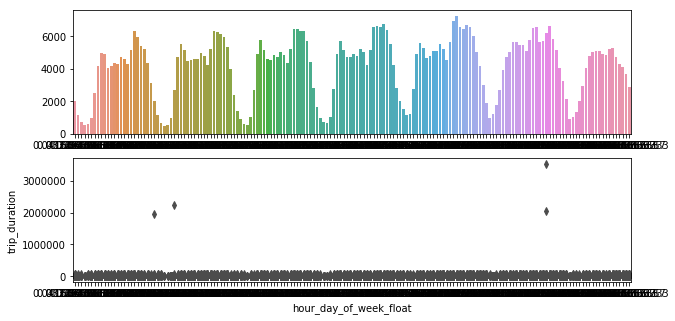

In [37]:
flg,ax = plt.subplots(nrows = 2, figsize=(10,5))
sns.barplot(c.index,c.values,ax=ax[0])
ax[0].set_xlabel(' ')
sns.boxplot(x = 'hour_day_of_week_float', y = 'trip_duration',
            data = train, palette = 'gist_rainbow', linewidth = 2.3,ax=ax[1])

>  요일별 시간 정보를 float로 표시함
> * hour/24 + day_of_week(0~6)
> * 유사한 경향을 보이는 것을 확인함

* day_of_week과 hour의 interation 또는 hour_day_of_week_float를 사용하여 day_of_week과 hour의 관계를 표현하기로 함

In [38]:
trip_duration_median = train['trip_duration'].median()
print (trip_duration_median)

648.0


### Use External Data

#### Accidents 
* All accidents in NEW York in 2016
[kaggle Homepage](https://inclass.kaggle.com/oscarleo/new-york-city-taxi-with-osrm/data)


In [50]:
accident = pd.read_csv('./data/accidents_2016.csv')

In [52]:
accident['datetime']=accident.apply(lambda x:datetime.strptime(x.datetime, '%Y-%m-%d %H:%M:%S'), axis = 1)

In [53]:
accident['timeIs'] = accident['datetime'].dt.time # Extract date
accident['dateIs'] = accident['datetime'].dt.date # Extract time
accident['year'] = accident['datetime'].dt.year
accident['month'] = accident['datetime'].dt.month
accident['day'] = accident['datetime'].dt.day
accident['hr'] = accident['datetime'].dt.hour
accident['minute'] = accident['datetime'].dt.minute
accident = accident[:][datetime.strptime('2016-01-01', '%Y-%m-%d') <=accident['datetime']]
accident = accident[:][accident['datetime'] <= datetime.strptime('2016-05-01', '%Y-%m-%d')]

In [54]:
accident_By_Date = accident.groupby('dateIs').count()['UNIQUE KEY']

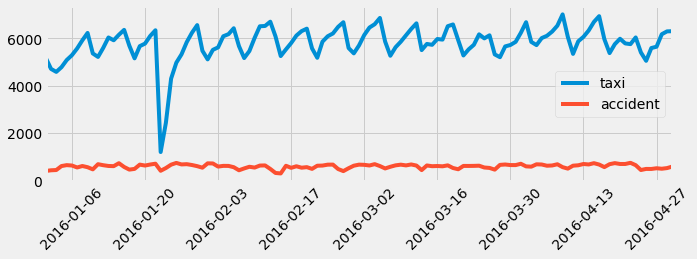

In [55]:
#data_and_accident = pd.concat([pickups_by_day,accident_By_Date], axis = 1)
d1 = pickups_by_day.to_frame()
d2 = accident_By_Date.to_frame()
df = pd.merge(d1,d2,left_index =True, right_index = True)
df.rename(columns={df.columns[0]:'taxi', df.columns[1]:'accident'},inplace = True)
df.plot(figsize = (10,3),legend = True,rot = 45)

* 2016년 1월 23일, 2016년 1월 24일 택시 이용량이 낮게 나타남을 확인  
> - 교통사고 발생으로 인한 영향인 것으로 생각하고 외부에서 2016년 뉴욕의 교통사고 정보를 얻어서 분석을 진행함. -> 큰 영향이 없음 확인   
> - 인터넷 검색을 통하여 2016년 1월 22일 ~ 2016년 1월 23일 뉴욕에 26.8인치의 기록적인 적설이 있었음을 확인  
 
* 날씨를 변수로 추가하기로 함

#### Weather
* Weather in NEW York in 2016 [kaggle Homepage](https://www.kaggle.com/maheshdadhich/strength-of-visualization-python-visuals-tutorial/data)

In [56]:
weatherData = pd.read_csv('./data/KNYC_Metars.csv')

In [57]:
weatherData.tail()

,Time,Temp.,Windchill,Heat Index,Humidity,Pressure,Dew Point,Visibility,Wind Dir,Wind Speed,Gust Speed,Precip,Events,Conditions
8782,2017-01-01 21:00:00,5.0,3.3,NaN,0.43,1028.5,-6.7,16.1,ENE,7.4,0.0,0.0,None,Clear
8783,2017-01-01 22:00:00,5.6,3.6,NaN,0.38,1029.3,-7.8,16.1,NE,9.3,0.0,0.0,None,Clear
8784,2017-01-01 23:00:00,5.6,4.0,NaN,0.38,1030.2,-7.8,16.1,NE,7.4,0.0,0.0,None,Clear
8785,2017-01-02 00:00:00,5.0,3.3,NaN,0.41,1030.6,-7.2,16.1,ENE,7.4,0.0,0.0,None,Clear
8786,2017-01-02 01:00:00,5.0,2.1,NaN,0.43,1030.1,-6.7,16.1,ENE,13.0,0.0,0.0,None,Clear


In [58]:
weatherData['Time'] = pd.to_datetime(weatherData['Time'])

In [59]:
weatherData['year'] = weatherData['Time'].dt.year
weatherData['month'] = weatherData['Time'].dt.month
weatherData['day'] = weatherData['Time'].dt.day
weatherData['hr'] = weatherData['Time'].dt.hour
weatherData['pickup_date'] = weatherData['Time'].dt.date
weatherData = weatherData[:][datetime.strptime('2015-12-31', '%Y-%m-%d') <=weatherData['Time']]
weatherData = weatherData[:][weatherData['Time'] <= datetime.strptime('2016-05-01', '%Y-%m-%d')]

In [60]:
weatherData['Event']= 1*(weatherData.Events=='Snow') + 1*(weatherData.Events=='Fog\n\t,\nSnow')

* 눈이나 비가 왔는지에 따라 0,1의 value를 주어 구분을 함
 * 0 : 아무 일도 없음
 * 1 : 눈이 왔음

In [61]:
weatherData = weatherData[weatherData['year'] == 2016][['year','month','day','hr','Event']]

In [62]:
train = pd.merge(train,weatherData,on = ['year','month','day','hr'],how = 'left')
train['Event'] = train['Event'].fillna(0)

,count,mean,std,min,25%,50%,75%,max
Event,,,,,,,,
0.0,692246.0,938.986496,6807.064208,1.0,391.0,649.0,1047.00,3526282.0
1.0,9532.0,920.236152,3432.903994,2.0,373.0,618.0,1001.25,86369.0


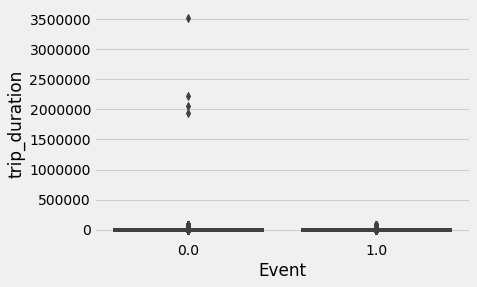

In [65]:
sns.boxplot(x= 'Event', y = 'trip_duration',data = train)
train.groupby(['Event'])['trip_duration'].describe()

* 눈이 왔을때 trip_duration이 짧은 경향을 보이나 outlier인 것으로 보이는 데이터의 영향이 있을 것으로 생각됨

#### Check whether date is rest 
* Holidays in NYC for 2016.
[Kaggle Homepage](https://www.kaggle.com/pceccon/nyc2016holidays/data)

In [66]:
holiday = pd.read_csv('./data/NYC_2016Holidays.csv',sep=';')
holiday['Date'] = holiday['Date'].apply(lambda x: x + ' 2016')
holidays = [datetime.strptime(holiday.loc[i,'Date'], '%B %d %Y').date() for i in range(len(holiday))]

In [67]:
rest_day,weekend = restday(train.year,train.month,train.day,holidays)
timeTrain = pd.DataFrame(index = range(len(train)))
timeTrain = timeTrain.assign(rest_day=rest_day)
timeTrain = timeTrain.assign(weekend=weekend)

In [69]:
train = pd.concat([train,timeTrain],axis = 1)

In [70]:
train.tail()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,year,month,day,hr,minute,day_of_week,hour_day_of_week_float,Event,rest_day,weekend
701773,id3888279,1,2016-01-01 00:01:00,2016-01-01 00:05:00,1,-73.982292,40.751331,-73.991341,40.750340,N,...,2016,1,1,0,1,4,4.0,0.0,True,False
701774,id1210365,2,2016-01-01 00:01:00,2016-01-01 00:07:00,5,-73.965279,40.801041,-73.947479,40.815170,N,...,2016,1,1,0,1,4,4.0,0.0,True,False
701775,id0924227,1,2016-01-01 00:01:00,2016-01-01 00:13:00,1,-73.970108,40.759800,-73.989357,40.742989,N,...,2016,1,1,0,1,4,4.0,0.0,True,False
701776,id0190469,2,2016-01-01 00:00:00,2016-01-01 00:14:00,5,-73.981743,40.719158,-73.938828,40.829182,N,...,2016,1,1,0,0,4,4.0,0.0,True,False
701777,id1665586,1,2016-01-01 00:00:00,2016-01-01 00:22:00,1,-73.985085,40.747166,-73.958038,40.717491,N,...,2016,1,1,0,0,4,4.0,0.0,True,False


In [71]:
train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,year,month,day,hr,minute,day_of_week,hour_day_of_week_float,Event
count,701778.000000,701778.000000,701778.000000,701778.000000,701778.000000,701778.000000,7.017780e+05,701778.0,701778.000000,701778.000000,701778.000000,701778.000000,701778.000000,701778.000000,701778.000000
mean,1.536037,1.666577,-73.973665,40.750969,-73.973583,40.751836,9.387318e+02,2016.0,2.542780,15.538534,13.637749,29.607258,3.078766,3.647005,0.013583
std,0.498700,1.319466,0.043910,0.033139,0.044214,0.037572,6.772504e+03,0.0,1.111019,8.702017,6.379120,17.324218,1.946370,1.942116,0.115750
min,1.000000,0.000000,-78.547401,34.359695,-79.817978,32.181141,1.000000e+00,2016.0,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,-73.991829,40.737400,-73.991325,40.735959,3.900000e+02,2016.0,2.000000,8.000000,9.000000,15.000000,1.000000,1.916667,0.000000
50%,2.000000,1.000000,-73.981789,40.754150,-73.979828,40.754478,6.480000e+02,2016.0,3.000000,15.000000,14.000000,30.000000,3.000000,3.750000,0.000000
75%,2.000000,2.000000,-73.967567,40.768246,-73.963249,40.769691,1.047000e+03,2016.0,4.000000,23.000000,19.000000,45.000000,5.000000,5.375000,0.000000
max,2.000000,8.000000,-61.335529,43.486885,-61.335529,43.674000,3.526282e+06,2016.0,4.000000,31.000000,23.000000,59.000000,6.000000,6.958333,1.000000


In [72]:
countrestDay = train['rest_day'].value_counts().sort_index()
print (countrestDay)

False    476775
True     225003
Name: rest_day, dtype: int64


,count,mean,std,min,25%,50%,75%,max
rest_day,,,,,,,,
False,476775.0,950.932115,5213.533971,1.0,402.0,668.0,1080.0,2227612.0
True,225003.0,912.879730,9244.510205,1.0,369.0,609.0,977.0,3526282.0


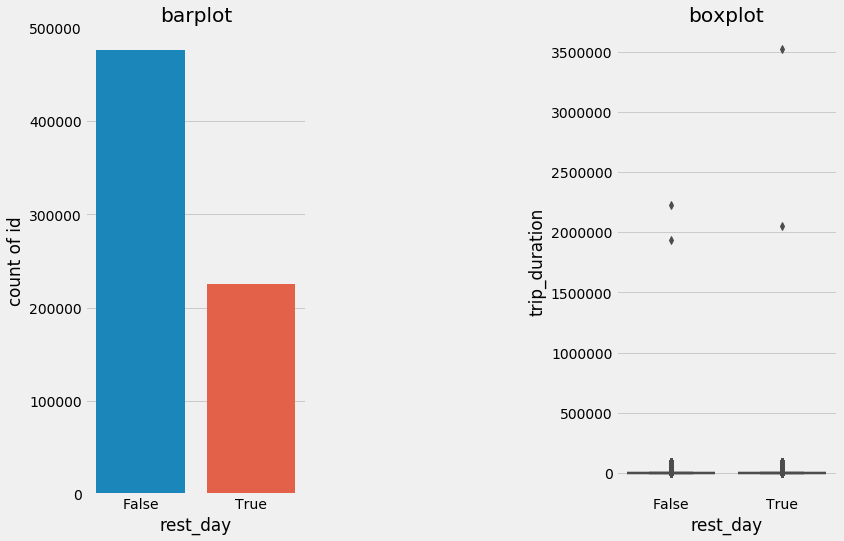

In [73]:
plt.figure(figsize=(12,8))
plt.subplot(131)
plt.title('barplot')
sns.barplot(countrestDay.index,countrestDay.values)
plt.xlabel('rest_day')
plt.ylabel('count of id')
plt.subplot(133)
plt.title('boxplot')
sns.boxplot(x = 'rest_day', y = 'trip_duration', data = train, 
                          palette = 'gist_rainbow', linewidth = 2.3)
train.groupby('rest_day')['trip_duration'].describe()

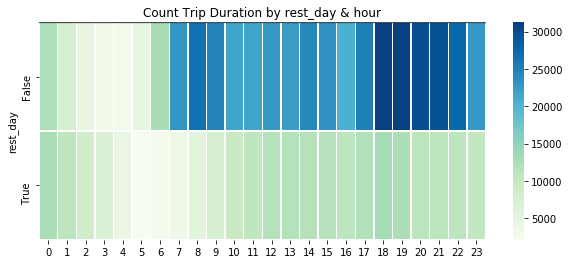

In [15]:
# Trips by Hour and Day of Week
plt.figure(figsize=(10,4))
pickup_restday = train.groupby(['rest_day','hr'])['trip_duration'].count().unstack()
hourday_graph = sns.heatmap(pickup_restday,
                                   lw = .5, cmap = 'GnBu', fmt = 'g' )

# Bolding horizontal line at y = 0
hourday_graph.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .70)

# Remove the label of the x-axis
hourday_graph.xaxis.label.set_visible(False)

# Remove the label of the x-axis
# Add signature bar
plt.title('Count Trip Duration by rest_day & hour')
plt.show()

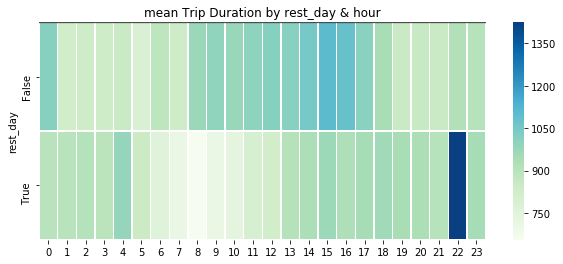

In [14]:
# Trips by Hour and Day of Week
plt.figure(figsize=(10,4))
pickup_restday = train.groupby(['rest_day','hr'])['trip_duration'].mean().unstack()
hourday_graph = sns.heatmap(pickup_restday,
                                   lw = .5, cmap = 'GnBu', fmt = 'g' )

# Bolding horizontal line at y = 0
hourday_graph.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .70)

# Remove the label of the x-axis
hourday_graph.xaxis.label.set_visible(False)

# Remove the label of the x-axis
# Add signature bar
plt.title('mean Trip Duration by rest_day & hour')
plt.show()

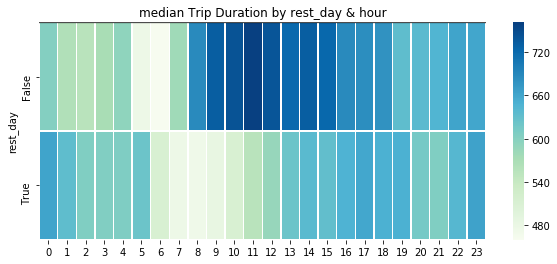

In [16]:
# Trips by Hour and Day of Week
plt.figure(figsize=(10,4))
pickup_restday = train.groupby(['rest_day','hr'])['trip_duration'].median().unstack()
hourday_graph = sns.heatmap(pickup_restday,
                                   lw = .5, cmap = 'GnBu', fmt = 'g' )

# Bolding horizontal line at y = 0
hourday_graph.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .70)

# Remove the label of the x-axis
hourday_graph.xaxis.label.set_visible(False)

# Remove the label of the x-axis
# Add signature bar
plt.title('median Trip Duration by rest_day & hour')
plt.show()

In [74]:
countWeekend = train['weekend'].value_counts().sort_index()
print (countWeekend)

False    498884
True     202894
Name: weekend, dtype: int64


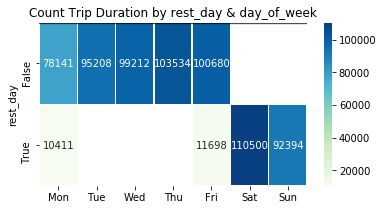

In [22]:
# Trips by Hour and Day of Week
plt.figure(figsize=(6,3))
pickup_restday = train.groupby(['rest_day','day_of_week'])['trip_duration'].count().unstack()
hourday_graph = sns.heatmap(pickup_restday,
                                   lw = .5, annot = True, cmap = 'GnBu', fmt = 'g',annot_kws = {"size":10} )

# Customize tick labels of the y-axis
hourday_graph.set_xticklabels(labels = ['Mon', 'Tue', 'Wed','Thu','Fri','Sat','Sun'])

# Bolding horizontal line at y = 0
hourday_graph.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .70)

# Remove the label of the x-axis
hourday_graph.xaxis.label.set_visible(False)

# Remove the label of the x-axis
# Add signature bar
plt.title('Count Trip Duration by rest_day & day_of_week')
plt.show()

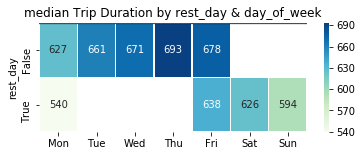

648.0


In [20]:
# Trips by Hour and Day of Week
plt.figure(figsize=(6,2))
pickup_restdayweek = train.groupby(['rest_day','day_of_week'])['trip_duration'].median().unstack()
hourday_graph = sns.heatmap(pickup_restdayweek,
                                   lw = .5, annot = True, cmap = 'GnBu', fmt = 'g',annot_kws = {"size":10} )
# Customize tick label size
hourday_graph.tick_params(axis = 'both', which = 'major', labelsize = 10)

# Customize tick labels of the y-axis
hourday_graph.set_xticklabels(labels = ['Mon', 'Tue', 'Wed','Thu','Fri','Sat','Sun'])

# Bolding horizontal line at y = 0
hourday_graph.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .70)

# Remove the label of the x-axis
hourday_graph.xaxis.label.set_visible(False)

# Add signature bar
plt.ylabel('rest_day')
plt.xlabel('pickup_weekday (Mon - Sun)')
plt.title('median Trip Duration by rest_day & day_of_week')
plt.show()
print (train['trip_duration'].median())

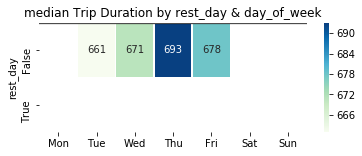

648.0


In [21]:
# Trips by Hour and Day of Week
plt.figure(figsize=(6,2))
pickup_restdayweek = train.groupby(['rest_day','day_of_week'])['trip_duration'].median().unstack()
hourday_graph = sns.heatmap(pickup_restdayweek[pickup_restdayweek > train['trip_duration'].median()],
                                   lw = .5, annot = True, cmap = 'GnBu', fmt = 'g',annot_kws = {"size":10} )
# Customize tick label size
hourday_graph.tick_params(axis = 'both', which = 'major', labelsize = 10)

# Customize tick labels of the y-axis
hourday_graph.set_xticklabels(labels = ['Mon', 'Tue', 'Wed','Thu','Fri','Sat','Sun'])

# Bolding horizontal line at y = 0
hourday_graph.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .70)

# Remove the label of the x-axis
hourday_graph.xaxis.label.set_visible(False)

# Add signature bar
plt.ylabel('rest_day')
plt.xlabel('pickup_weekday (Mon - Sun)')
plt.title('median Trip Duration by rest_day & day_of_week')
plt.show()
print (train['trip_duration'].median())

,count,mean,std,min,25%,50%,75%,max
weekend,,,,,,,,
False,498884.0,947.588570,5143.988708,1.0,399.0,664.0,1075.0,2227612.0
True,202894.0,916.954474,9673.843339,1.0,371.0,611.0,979.0,3526282.0


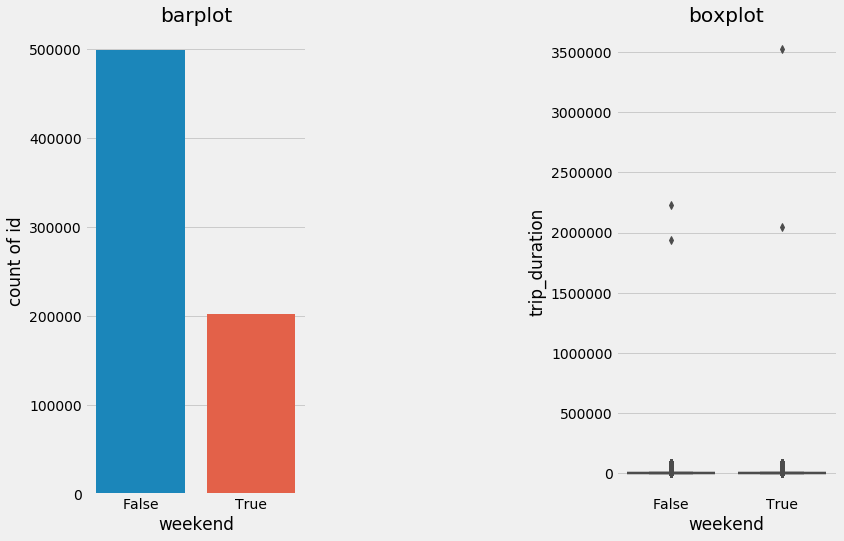

In [75]:
import matplotlib
matplotlib.style.use('fivethirtyeight')
plt.figure(figsize=(12,8))
plt.subplot(131)
plt.title('barplot')
sns.barplot(countWeekend.index,countWeekend.values)
plt.xlabel('weekend')
plt.ylabel('count of id')
plt.subplot(133)
plt.title('boxplot')
sns.boxplot(x = 'weekend', y = 'trip_duration', data = train, 
                          palette = 'gist_rainbow', linewidth = 2.3)
train.groupby('weekend')['trip_duration'].describe()

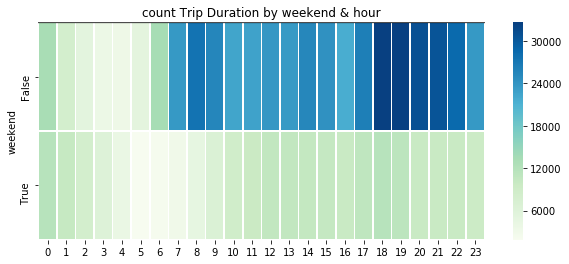

In [17]:
# Trips by Hour and Day of Week
plt.figure(figsize=(10,4))
pickup_restday = train.groupby(['weekend','hr'])['trip_duration'].count().unstack()
hourday_graph = sns.heatmap(pickup_restday,
                                   lw = .5, cmap = 'GnBu', fmt = 'g' )

# Bolding horizontal line at y = 0
hourday_graph.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .70)

# Remove the label of the x-axis
hourday_graph.xaxis.label.set_visible(False)

# Remove the label of the x-axis
# Add signature bar
plt.title('count Trip Duration by weekend & hour')
plt.show()

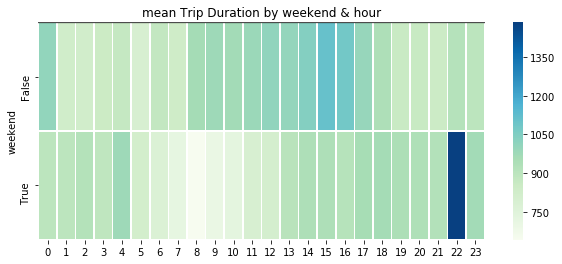

In [18]:
# Trips by Hour and Day of Week
plt.figure(figsize=(10,4))
pickup_restday = train.groupby(['weekend','hr'])['trip_duration'].mean().unstack()
hourday_graph = sns.heatmap(pickup_restday,
                                   lw = .5, cmap = 'GnBu', fmt = 'g' )

# Bolding horizontal line at y = 0
hourday_graph.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .70)

# Remove the label of the x-axis
hourday_graph.xaxis.label.set_visible(False)

# Remove the label of the x-axis
# Add signature bar
plt.title('mean Trip Duration by weekend & hour')
plt.show()

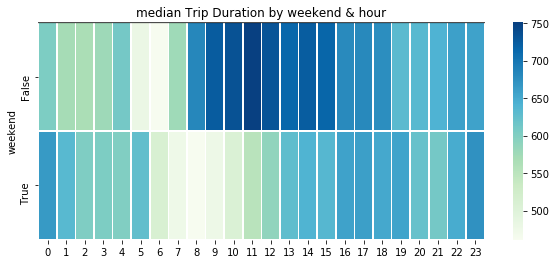

In [19]:
# Trips by Hour and Day of Week
plt.figure(figsize=(10,4))
pickup_restday = train.groupby(['weekend','hr'])['trip_duration'].median().unstack()
hourday_graph = sns.heatmap(pickup_restday,
                                   lw = .5, cmap = 'GnBu', fmt = 'g' )

# Bolding horizontal line at y = 0
hourday_graph.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .70)

# Remove the label of the x-axis
hourday_graph.xaxis.label.set_visible(False)

# Remove the label of the x-axis
# Add signature bar
plt.title('median Trip Duration by weekend & hour')
plt.show()

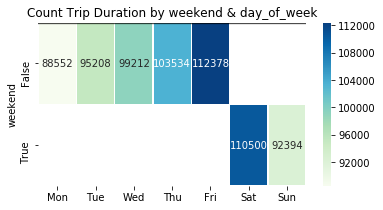

In [23]:
# Trips by Hour and Day of Week
plt.figure(figsize=(6,3))
pickup_restday = train.groupby(['weekend','day_of_week'])['trip_duration'].count().unstack()
hourday_graph = sns.heatmap(pickup_restday,
                                   lw = .5, annot = True, cmap = 'GnBu', fmt = 'g',annot_kws = {"size":10} )

# Customize tick labels of the y-axis
hourday_graph.set_xticklabels(labels = ['Mon', 'Tue', 'Wed','Thu','Fri','Sat','Sun'])

# Bolding horizontal line at y = 0
hourday_graph.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .70)

# Remove the label of the x-axis
hourday_graph.xaxis.label.set_visible(False)

# Remove the label of the x-axis
# Add signature bar
plt.title('Count Trip Duration by weekend & day_of_week')
plt.show()

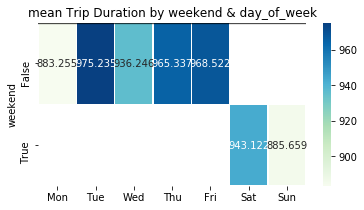

In [24]:
# Trips by Hour and Day of Week
plt.figure(figsize=(6,3))
pickup_restday = train.groupby(['weekend','day_of_week'])['trip_duration'].mean().unstack()
hourday_graph = sns.heatmap(pickup_restday,
                                   lw = .5, annot = True, cmap = 'GnBu', fmt = 'g',annot_kws = {"size":10} )

# Customize tick labels of the y-axis
hourday_graph.set_xticklabels(labels = ['Mon', 'Tue', 'Wed','Thu','Fri','Sat','Sun'])

# Bolding horizontal line at y = 0
hourday_graph.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .70)

# Remove the label of the x-axis
hourday_graph.xaxis.label.set_visible(False)

# Remove the label of the x-axis
# Add signature bar
plt.title('mean Trip Duration by weekend & day_of_week')
plt.show()

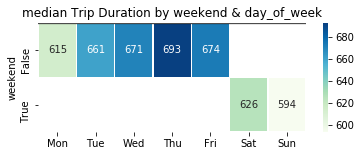

648.0


In [28]:
# Trips by Hour and Day of Week
plt.figure(figsize=(6,2))
pickup_restdayweek = train.groupby(['weekend','day_of_week'])['trip_duration'].median().unstack()
hourday_graph = sns.heatmap(pickup_restdayweek,
                                   lw = .5, annot = True, cmap = 'GnBu', fmt = 'g',annot_kws = {"size":10} )
# Customize tick label size
hourday_graph.tick_params(axis = 'both', which = 'major', labelsize = 10)

# Customize tick labels of the y-axis
hourday_graph.set_xticklabels(labels = ['Mon', 'Tue', 'Wed','Thu','Fri','Sat','Sun'])

# Bolding horizontal line at y = 0
hourday_graph.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .70)

# Remove the label of the x-axis
hourday_graph.xaxis.label.set_visible(False)

# Add signature bar
plt.xlabel('pickup_weekday (Mon - Sun)')
plt.title('median Trip Duration by weekend & day_of_week')
plt.show()
print (train['trip_duration'].median())

* 모델을 구성할때 weekend와 day_of_week은 연관성은 고려하지 않아도 될 것으로 보임

### New Feature using internal

#### Distance Column 추가
* pickup의 longitude, latitude와 dropoff의 longitude, latitude를 사용하여 두 지점사이의 거리를 구할 수 있다. 


In [82]:
train['distance'] = train.apply(lambda x:haversine_array(x.pickup_latitude, x.pickup_longitude, x.dropoff_latitude, x.dropoff_longitude), axis =1 )

* distance
 * the direct distance of two GPS location, taking into account that the earth is round.

In [83]:
train['distance'].describe()

count    701778.000000
mean          3.397331
std           4.248709
min           0.000000
25%           1.221590
50%           2.072920
75%           3.823712
max         891.214104
Name: distance, dtype: float64

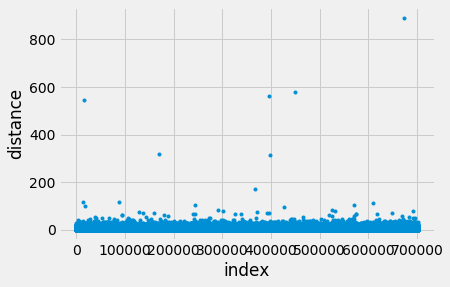

In [84]:
plt.plot(range(len(train['distance'])),train['distance'],'.');plt.ylabel('distance');plt.xlabel('index');plt.show()

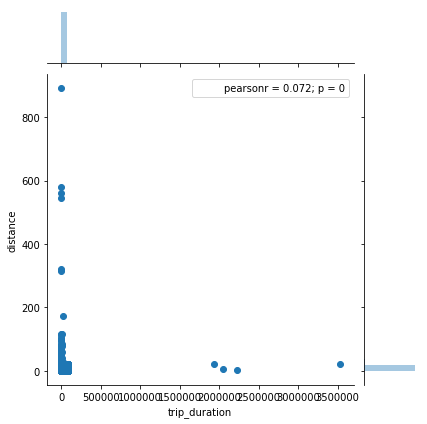

In [29]:
sns.jointplot(x = 'trip_duration', y = 'distance',data=train)

* 두 지점의 직선 거리와 실제 이동거리는 다르므로 좀 더 정확한 거리 정보를 이용하는 것이 좋을 것으로 판단

Index(['trip_duration', 'distance'], dtype='object')


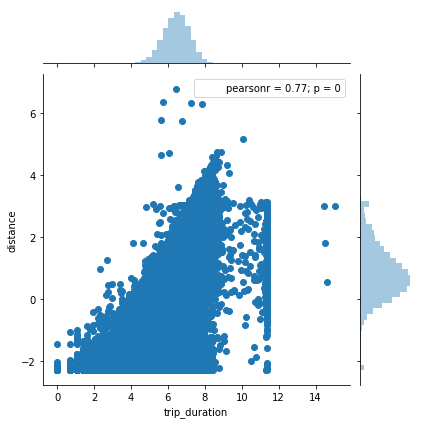

In [39]:
y2 = train.apply(lambda x: np.log(x.distance+0.1), axis = 1)
x2 = train.apply(lambda x:np.log(x.trip_duration),axis = 1)
z2 = pd.concat([x2,y2],axis =1)
z2= z2.rename(columns = {0:'trip_duration',1:'distance'})
print (z2.keys())
sns.jointplot(x = 'trip_duration', y='distance',data = z2)

#### Dummy_manhattan_dist column 추가
* 격자를 기반으로 하는 측정 체계
 * 2개의 점들 간의 거리는 각 방향 직각의 거리나 격자 셀 수로 정의

In [85]:
train['dummy_manhattan_dist'] = train.apply(lambda x:dummy_manhattan_distance(x.pickup_latitude, x.pickup_longitude, x.dropoff_latitude, x.dropoff_longitude), axis =1 )

* Manhattan distance 
 * the usual L1 distance
 * to calculate each coordinate of distance.

In [86]:
train['dummy_manhattan_dist'].describe()

count    701778.000000
mean          4.389819
std           5.680476
min           0.000000
25%           1.558700
50%           2.661343
75%           4.937964
max        1282.539301
Name: dummy_manhattan_dist, dtype: float64

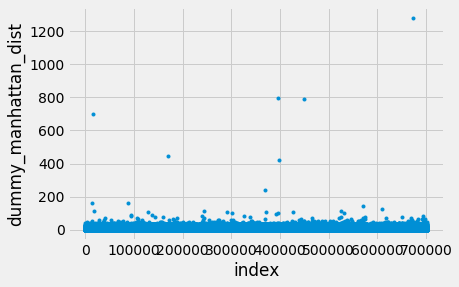

In [87]:
plt.plot(range(len(train['dummy_manhattan_dist'])),train['dummy_manhattan_dist'],'.');plt.ylabel('dummy_manhattan_dist');plt.xlabel('index');plt.show()

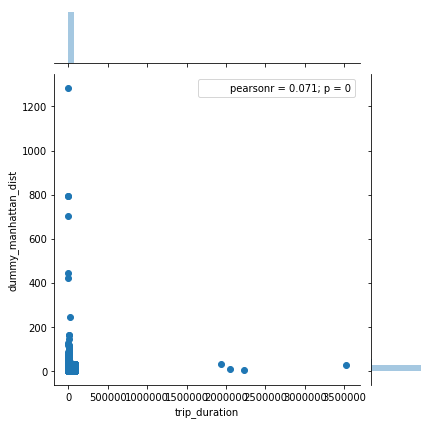

In [30]:
sns.jointplot(x = 'trip_duration', y = 'dummy_manhattan_dist',data=train)

Index(['trip_duration', 'dummy_manhattan_dist'], dtype='object')


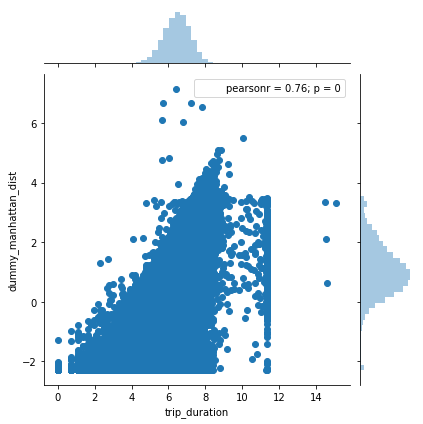

In [41]:
y2 = train.apply(lambda x: np.log(x.dummy_manhattan_dist+0.1), axis = 1)
x2 = train.apply(lambda x:np.log(x.trip_duration),axis = 1)
z2 = pd.concat([x2,y2],axis =1)
z2= z2.rename(columns = {0:'trip_duration',1:'dummy_manhattan_dist'})
print (z2.keys())
sns.jointplot(x = 'trip_duration', y='dummy_manhattan_dist',data = z2)

#### bearing column 추가

* Bearing
  * The direction of the trip. Using radian as unit

In [88]:
train['bearing'] = train.apply(lambda x:bearing_array(x.pickup_latitude, x.pickup_longitude, x.dropoff_latitude, x.dropoff_longitude), axis =1 )

In [89]:
train['bearing'].describe()

count    701778.000000
mean        -15.645382
std         104.550119
min        -179.991119
25%        -125.405469
50%           8.156021
75%          53.621323
max         180.000000
Name: bearing, dtype: float64

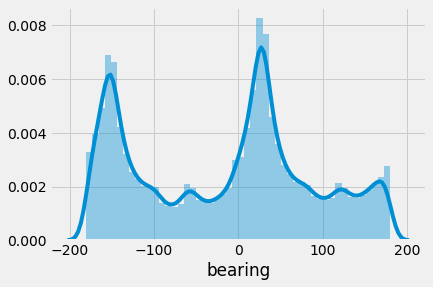

In [91]:
sns.distplot(train['bearing'])

In [2]:
train = pd.read_csv('./data/transformed_train.csv')

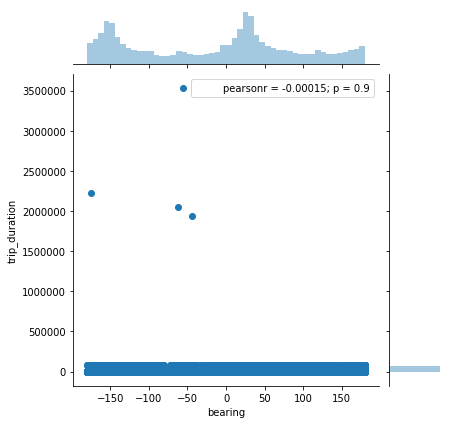

In [3]:
sns.jointplot(x='bearing',y='trip_duration',data = train)

Index(['bearing', 0], dtype='object')


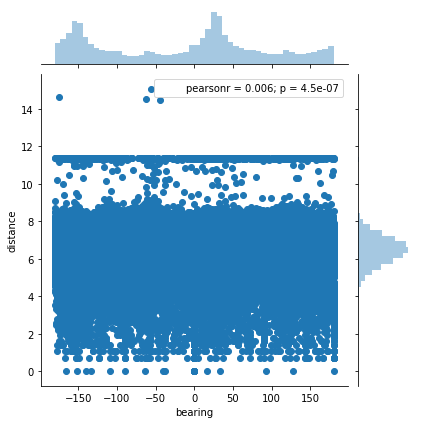

In [5]:
y2 = train.apply(lambda x:np.log(x.trip_duration),axis = 1)
z2 = pd.concat([train['bearing'],y2],axis =1)
print (z2.keys())
z2= z2.rename(columns = {0:'distance'})
sns.jointplot(x = 'bearing', y='distance',data = z2)

### location information
> * longitude (경도)
>  * 적도를 기준으로 북쪽 또는 남쪽으로 얼마나 떨어져 있는지 나타내는 위치
> * latitude (위도)
>  * 적도를 기준으로 북쪽 또는 남쪽으로 얼마나 떨어져 있는지 나타내는 위치

#### Pickup

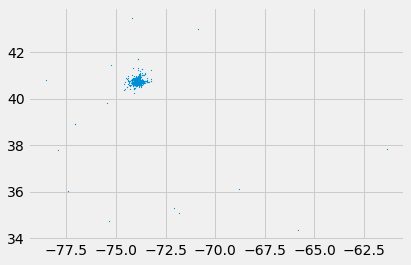

In [116]:
plt.scatter(train['pickup_longitude'],train['pickup_latitude'], s=0.5, alpha=1)

* 경향
 * longitute (경도) : -75 ~ -72
 * latitude (위도) : 40 ~ 42
 - 집중되어 있는 것을 확인할 수 있음
* 범위를 조절하면서 집중되어 있는 위치에 대하여 그래프

#### dropoff

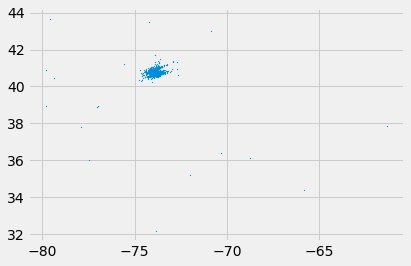

In [118]:
plt.scatter(train['dropoff_longitude'],train['dropoff_latitude'], s=0.5, alpha=1)

* 경향
 * longitute (경도) : -75 ~ -72
 * latitude (위도) : 40 ~ 42
 - 집중되어 있는 것을 확인할 수 있음
* 범위를 조절하면서 집중되어 있는 위치에 대하여 그래프

#### Pickup & Dropof location

Text(0.5,1,'dropoff')

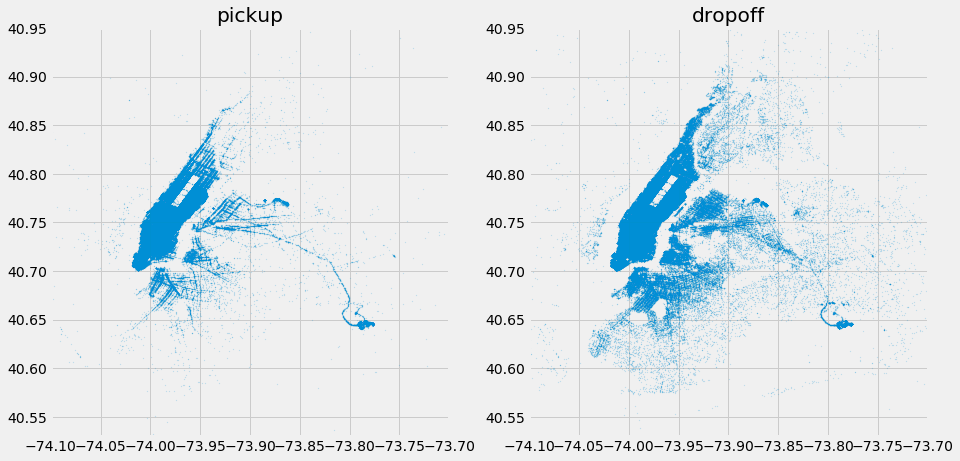

In [119]:
fig, ax = plt.subplots(ncols=2, figsize=(14,7))
ax[0].set_ylim(40.53, 40.95)
ax[0].set_xlim(-74.1,-73.70)
ax[0].plot(train['pickup_longitude'],train['pickup_latitude'],'.',  alpha=0.4, markersize = 0.4)
ax[0].set_title('pickup')
ax[1].set_ylim(40.53, 40.95)
ax[1].set_xlim(-74.1,-73.70)
ax[1].plot(train['dropoff_longitude'],train['dropoff_latitude'],'.', alpha=0.4, markersize = 0.4)
ax[1].set_title('dropoff')

![newyork map](./data/NYC_boroughs_b.jpg)
[구글맵:뉴욕](https://www.google.co.kr/maps/place/%EB%AF%B8%EA%B5%AD+%EB%89%B4%EC%9A%95/@40.7766932,-74.2068077,10.25z/data=!4m5!3m4!1s0x89c24fa5d33f083b:0xc80b8f06e177fe62!8m2!3d40.7127753!4d-74.0059728)
* 구글맵을 통하여 위의 그래프에서 나타난 그림의 특성을 비교해보았을때 뉴욕의 지도와 비슷하다는 것을 파악
 * Manhattan
   * 40.8, -73.95 부근의 사각형 모형은 뉴욕의 central park
 * John F. Kennedy Airport - Queens주에 위치 
 * LaGuardia Airport - Queens주에 위치
 

#### 뉴욕주의 GPS 정보를 활용하여 해당 데이터의 pickup 위치와 dropoff 가 뉴욕주중 어디인지를 확인함
> * Staten Island
> * Bronx
> * Queens
> * Brooklyn
> * Manhattan
> * outward

#### Geojson 파일을 불러들여 뉴욕 각 주의 구역을 정의함

[NYC OpenData](https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm/data#)

In [110]:
with open('./data/BoroughBoundaries.geojson') as f:
    data = geojson.load(f)
das = dict()
for feature in data['features']:
    boro_name = feature['properties']['boro_name']
    shape_leng = feature['properties']['shape_leng']
    shape_area = feature['properties']['shape_area']
    coords = feature['geometry']['coordinates']
    binList = []
    print (boro_name, shape_area)
    for i in coords:
        for j in i:
            binList.append([j,[]])
    das[boro_name] = MultiPolygon(binList)

Staten Island 1623914222.74
Bronx 1186678192.09
Queens 3044779902.31
Brooklyn 1937477754.43
Manhattan 636479884.362


#### GPS 정보를 활용하여 해당 정보가 포함하는 뉴욕의 주 찾기

In [111]:
def CheckProvince(daf, long1, lati1):
    gpsPointIs = Point(long1,lati1)
    provinceIs = ','.join(list(filter(lambda x: daf[x].contains(gpsPointIs), daf.keys())))
    if provinceIs =='':
        provinceIs = 'outward'
    return provinceIs

In [112]:
train['pickup_Province'] =train.apply(lambda x: CheckProvince(das, x.pickup_longitude, x.pickup_latitude), axis =1)

In [113]:
train['dropoff_Province'] = train.apply(lambda x: CheckProvince(das, x.dropoff_longitude, x.dropoff_latitude), axis =1)

#### Pickup 주와 dropoff 주에 따른 데이터량

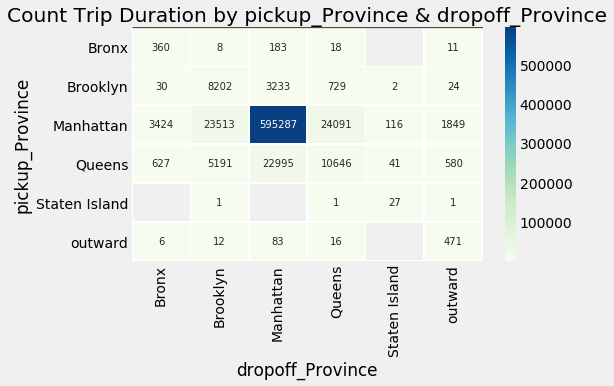

In [121]:
# Trips by Hour and Day of Week
plt.figure(figsize=(7,4))
provinceInfo = train.groupby(['pickup_Province','dropoff_Province'])['trip_duration'].count().unstack()
hourday_graph = sns.heatmap(provinceInfo,
                                   lw = .5, annot = True, cmap = 'GnBu', fmt = 'g',annot_kws = {"size":10} )

# Bolding horizontal line at y = 0
hourday_graph.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .70)
# Add signature bar
plt.title('Count Trip Duration by pickup_Province & dropoff_Province')
plt.show()

* Manhattan - manhattan이 가장 많은 데이터량을 보임

#### Pickup 주와 dropoff 주에 따른 trip_duration에 대한 정보

> #### Pickup 주와 dropoff 주에 따른 trip duration의 평균

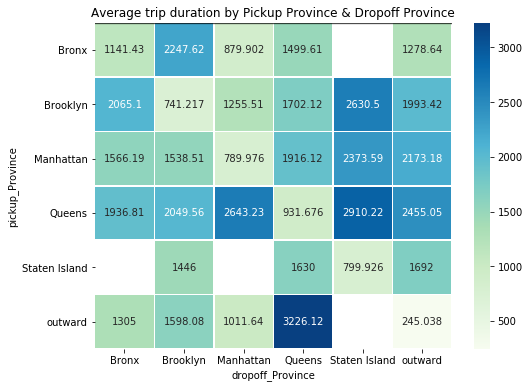

Event                                     \
                                     count      mean       std  min  25%  50%   
pickup_Province dropoff_Province                                                
Bronx           Bronx                360.0  0.016667  0.128197  0.0  0.0  0.0   
                Brooklyn               8.0  0.000000  0.000000  0.0  0.0  0.0   
                Manhattan            183.0  0.010929  0.104254  0.0  0.0  0.0   
                Queens                18.0  0.000000  0.000000  0.0  0.0  0.0   
                outward               11.0  0.000000  0.000000  0.0  0.0  0.0   
Brooklyn        Bronx                 30.0  0.033333  0.182574  0.0  0.0  0.0   
                Brooklyn            8202.0  0.014874  0.121058  0.0  0.0  0.0   
                Manhattan           3233.0  0.018868  0.136080  0.0  0.0  0.0   
                Queens               729.0  0.013717  0.116395  0.0  0.0  0.0   
                Staten Island          2.0  0.000000  0.000000  0.0  0.0  0.0   
                outward               24.0  0.000000  0.000000  0.0  0.0  0.0   
Manhattan       Bronx               3424.0  0.017523  0.131230  0.0  0.0  0.0   
                Brooklyn           23513.0  0.010122  0.100100  0.0  0.0  0.0   
                Manhattan         595287.0  0.013617  0.115895  0.0  0.0  0.0   
                Queens             24091.0  0.014570  0.119825  0.0  0.0  0.0   
                Staten Island        116.0  0.008621  0.092848  0.0  0.0  0.0   
                outward             1849.0  0.015143  0.122156  0.0  0.0  0.0   
Queens          Bronx                627.0  0.019139  0.137122  0.0  0.0  0.0   
                Brooklyn            5191.0  0.014063  0.117761  0.0  0.0  0.0   
                Manhattan          22995.0  0.012394  0.110639  0.0  0.0  0.0   
                Queens             10646.0  0.015123  0.122048  0.0  0.0  0.0   
                Staten Island         41.0  0.000000  0.000000  0.0  0.0  0.0   
                outward              580.0  0.018966  0.136521  0.0  0.0  0.0   
Staten Island   Brooklyn               1.0  0.000000       NaN  0.0  0.0  0.0   
                Queens                 1.0  0.000000       NaN  0.0  0.0  0.0   
                Staten Island         27.0  0.000000  0.000000  0.0  0.0  0.0   
                outward                1.0  0.000000       NaN  0.0  0.0  0.0   
outward         Bronx                  6.0  0.000000  0.000000  0.0  0.0  0.0   
                Brooklyn              12.0  0.000000  0.000000  0.0  0.0  0.0   
                Manhattan             83.0  0.012048  0.109764  0.0  0.0  0.0   
                Queens                16.0  0.000000  0.000000  0.0  0.0  0.0   
                outward              471.0  0.006369  0.079639  0.0  0.0  0.0   

                                             bearing             ...   \
                                  75%  max     count        mean ...    
pickup_Province dropoff_Province                                 ...    
Bronx           Bronx             0.0  1.0     360.0   -2.492887 ...    
                Brooklyn          0.0  0.0       8.0 -157.766232 ...    
                Manhattan         0.0  1.0     183.0 -114.579448 ...    
                Queens            0.0  0.0      18.0   87.368590 ...    
                outward           0.0  0.0      11.0   -9.331715 ...    
Brooklyn        Bronx             0.0  1.0      30.0   18.547487 ...    
                Brooklyn          0.0  1.0    8202.0   14.415087 ...    
                Manhattan         0.0  1.0    3233.0  -21.028131 ...    
                Queens            0.0  1.0     729.0   59.031760 ...    
                Staten Island     0.0  0.0       2.0 -124.942963 ...    
                outward           0.0  0.0      24.0  -62.689561 ...    
Manhattan       Bronx             0.0  1.0    3424.0   40.255745 ...    
                Brooklyn          0.0  1.0   23513.0   81.337653 ...    
                Manhattan        

In [4]:
# Trips by Hour and Day of Week
plt.figure(figsize=(8,6))
pickup_trip_duration = train.groupby(['pickup_Province','dropoff_Province'])['trip_duration'].mean().unstack()
hourday_graph = sns.heatmap(pickup_trip_duration,
                                   lw = .5, annot = True, cmap = 'GnBu', fmt = 'g',annot_kws = {"size":10} )
# Customize tick label size
hourday_graph.tick_params(axis = 'both', which = 'major', labelsize = 10)

# Bolding horizontal line at y = 0
hourday_graph.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .70)
# Add signature bar
plt.title('Average trip duration by Pickup Province & Dropoff Province')
plt.show()
train.groupby(['pickup_Province','dropoff_Province']).describe()

> #### Pickup 주와 dropoff 주에 따른 trip duration의 median

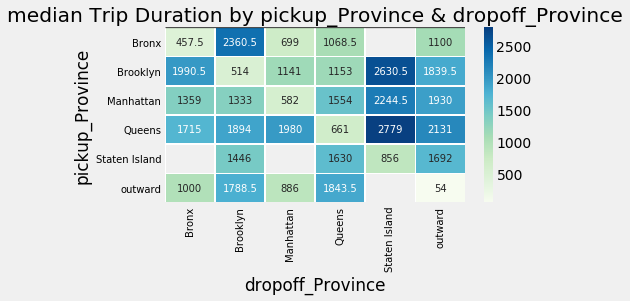

In [123]:
plt.figure(figsize=(6,3))
provinceInfo = train.groupby(['pickup_Province','dropoff_Province'])['trip_duration'].median().unstack()
p_graph = sns.heatmap(provinceInfo,
                                   lw = .5, annot = True, cmap = 'GnBu', fmt = 'g',annot_kws = {"size":10} )
# Customize tick label size
p_graph.tick_params(axis = 'both', which = 'major', labelsize = 10)

# Bolding horizontal line at y = 0
p_graph.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .70)
# Add signature bar
plt.title('median Trip Duration by pickup_Province & dropoff_Province')
plt.show()

648.0


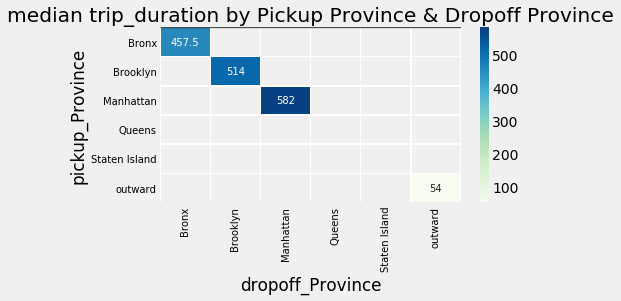

count         mean           std     min  \
pickup_Province dropoff_Province                                                
Bronx           Bronx                360.0  1141.433333   6668.816521     2.0   
                Brooklyn               8.0  2247.625000    315.867485  1696.0   
                Manhattan            183.0   879.901639    598.490428    57.0   
                Queens                18.0  1499.611111    890.323216   615.0   
                outward               11.0  1278.636364    786.434139   529.0   
Brooklyn        Bronx                 30.0  2065.100000    560.606097  1027.0   
                Brooklyn            8202.0   741.217264   3253.727255     1.0   
                Manhattan           3233.0  1255.510362   1612.013985   119.0   
                Queens               729.0  1702.124829   5718.312365    62.0   
                Staten Island          2.0  2630.500000    894.490078  1998.0   
                outward               24.0  1993.416667    877.484147   496.0   
Manhattan       Bronx               3424.0  1566.193925   2925.081328   142.0   
                Brooklyn           23513.0  1538.506231   3044.994844    15.0   
                Manhattan         595287.0   789.976447   4206.130584     1.0   
                Queens             24091.0  1916.118717   3775.060293   142.0   
                Staten Island        116.0  2373.586207    670.148265  1059.0   
                outward             1849.0  2173.182802   3422.085402   104.0   
Queens          Bronx                627.0  1936.811802    855.507388   529.0   
                Brooklyn            5191.0  2049.555770   1510.157982   111.0   
                Manhattan          22995.0  2643.228528  29994.198243    55.0   
                Queens             10646.0   931.676029   2775.329410     1.0   
                Staten Island         41.0  2910.219512    842.485564  1777.0   
                outward              580.0  2455.048276   1842.533352   184.0   
Staten Island   Brooklyn               1.0  1446.000000           NaN  1446.0   
                Queens                 1.0  1630.000000           NaN  1630.0   
                Staten Island         27.0   799.925926    591.082379     4.0   
                outward                1.0  1692.000000           NaN  1692.0   
outward         Bronx                  6.0  1305.000000   1348.317470   229.0   
                Brooklyn              12.0  1598.083333    681.243176   137.0   
                Manhattan             83.0  1011.638554    767.570186    18.0   
                Queens                16.0  3226.125000   5471.564930   554.0   
                outward              471.0   245.038217    417.596220     2.0   

                                      25%     50%      75%        max  
pickup_Province dropoff_Province                                       
Bronx           Bronx              200.75   457.5   735.25    86283.0  
                Brooklyn          2120.25  2360.5  2412.00     2617.0  
                Manhattan          495.50   699.0  1101.00     3160.0  
                Queens             872.50  1068.5  2032.75     3425.0  
                outward            814.00  1100.0  1185.00     3089.0  
Brooklyn        Bronx             1673.00  1990.5  2388.75     3188.0  
                Brooklyn           311.00   514.0   813.75    86288.0  
                Manhattan          799.00  1141.0  1550.00    86147.0  
                Queens             813.00  1153.0  1608.00    86262.0  
                Staten Island     2314.25  2630.5  2946.75     3263.0  
                outward           1316.25  1839.5  2505.25     3761.0  
Manhattan       Bronx             1010.00  1359.0  1788.25    86366.0  
                Brooklyn           992.00  1333.0  1764.00    86347.0  
                Manhattan          363.00   582.0   890.00  2227612.0  
                Queens            1157.00  1554.0  2143.00    86333.0  
                Staten Island     1889.50  2244.5  2735.25

In [124]:
trip_duration_median = train['trip_duration'].median()
print (trip_duration_median)
plt.figure(figsize=(6,3))
pickup_trip_duration = train.groupby(['pickup_Province','dropoff_Province'])['trip_duration'].median().unstack()
hourday_graph = sns.heatmap(pickup_trip_duration[pickup_trip_duration<trip_duration_median],
                                   lw = .5, annot = True, cmap = 'GnBu', fmt = 'g',annot_kws = {"size":10} )
# Customize tick label size
hourday_graph.tick_params(axis = 'both', which = 'major', labelsize = 10)

# Bolding horizontal line at y = 0
hourday_graph.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .70)

# Add signature bar
plt.title('median trip_duration by Pickup Province & Dropoff Province')
plt.show()
train.groupby(['pickup_Province','dropoff_Province'])['trip_duration'].describe()

* pickup과 dropoff의 province가 같은지에 따라 trip_duration이 차이를 보이는 것으로 보임
* pickup과 dropoff의 province가 같은지를 알려주는 변수를 추가

#### Pickup의 province와 Dropoff의 province가 같은지 여부를 확인

In [128]:
def SameProvince(x):
    if x['pickup_Province']==x['dropoff_Province']:
        return 1
    else:
        return 0
train['pickup_dropoff_same_Province']= train.apply(lambda x:SameProvince(x),axis = 1)

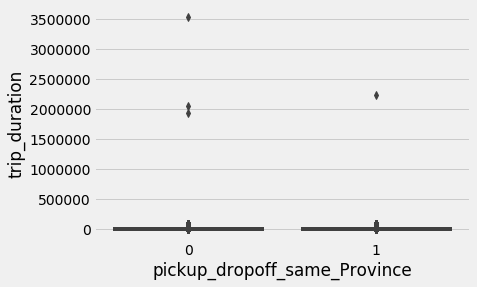

In [129]:
sns.boxplot(x= 'pickup_dropoff_same_Province', y = 'trip_duration',data = train)

In [153]:
train.groupby(['pickup_dropoff_same_Province'])['trip_duration'].describe()

,count,mean,std,min,25%,50%,75%,max
pickup_dropoff_same_Province,,,,,,,,
0,86785.0,1981.593755,15689.858326,15.0,1149.0,1585.0,2183.0,3526282.0
1,614993.0,791.567909,4174.438206,1.0,362.0,582.0,892.0,2227612.0


> #### Pickup 주와 dropoff 주에 따른 trip_duration의 median 중에서 전체 median보다 작은 값

#### data를 선별하기 위하여 속도 변수를 추가함

#### 속도 변수

In [92]:
train['speed_kmph'] =train.apply( lambda x: x['distance']/(x['trip_duration'] / 3600), axis = 1)

#### dummy manhattan dist를 이용한 속도 변수 추가

In [99]:
train['speed_kmph_dummy'] =train.apply( lambda x: x['dummy_manhattan_dist']/(x['trip_duration'] / 3600), axis = 1)

#### Feature
> * id : identical value
* vendor_id : category value
* pickup_datetime : time-series
* dropoff_datetime : time-series, test dataset에서는 생략
* passenger_count : real number
* pickup_longitude
* pickup_latitude
* dropoff_longitude
* dropoff_latitude
* pickup_date 
* pickup_time
* month : real value(1~12). 픽업 월
* day : real value(1~31). 픽업 일자 
* hr : real value(0~23). 픽업 시간대
* minute : real value(0~59). 픽업시간의 분
* day_of_week : real value(0~6). 요일 
* hour_day_of_week_float : continuous value. 요일 + 시간대
* Event : category value(0,1,2) 날씨 변수 
* rest_day : category value(0,1). 공휴일 여부(토/일 포함)
* weekend : category value(0,1). 주말(토/일)여부
* distance : continuous value
* dummy_manhattan_dist : contiuous value
* bearing : continuous value 
* pickup_Province : category value
* dropoff_Province : category value
* pickup_dropoff_same_Province : category value(0,1). 출발지와 목적지 Province가 같은지의 여부 
> * rest_day, weekend, day_of_week중 하나와 hr 사이의 interaction을 통하여 모델을 만드는 것이 필요함
* distance와 dummy_manhattan_dist는 real variable로 log(x+0.1)를 사용하여 normalization을 실시함
* pickup_Province와 dropoff_Province는 모델을 만들때 사용하여야 할 변수

### EDA 과정 중 시간이 오래 걸리는 작업이 있어서 지금까지 EDA 과정을 통해 생성된 데이터를 저장하여 사용함

In [ ]:
train.drop(['minute'],inplace = True, axis = 1)
train.drop(['year'],inplace = True, axis = 1)

In [186]:
train.to_csv('./data/transformed_train.csv',index=False)

* 추가 작업 및 여러 작업을 같이 하기 위하여 데이터를 저장함